In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from emissions import emissions

In [2]:
# global values (initial values)

# Define time step and total simulation time
# dt = 0.01  # Time step (years)
# T = 100  # Total simulation time (years)
# n_steps = int(T / dt)  # Number of time steps

n_boxes = 9

# Define initial carbon masses (burdens) in boxes (units Gt)
"""
M1 = 725  # Atmosphere
M2 = 725  # Surface Ocean
M5 = 110  # Short-lived biota
M7 = 60  # Deep Ocean
"""
Mi0 = np.array([725,725,0,0,110,0,60,0,0])
Mi0_perturbed = np.array([1000,725,0,0,110,0,60,0,0])

# Define initial fluxes (Gt/year)
F_12 = 90  # Flux from Atmosphere to Surface Ocean
F_21 = 90  # Flux from Surface Ocean to Atmosphere
F_71 = 55  # Flux from Deep Ocean to Atmosphere
F_57 = 55  # Flux from Short-lived Biota to Deep Ocean
F_15 = 110  # Flux from Atmosphere to Short-lived Biota
F_51 = 55  # Flux from Short-lived Biota to Atmosphere
F_72 = 0  # Flux from Deep Ocean to Surface Ocean

# Define initial flux matrix (n x n)
Fi0 = np.zeros((n_boxes, n_boxes))
Fi0[0,1] = F_12
Fi0[1,0] = F_21
Fi0[6,0] = F_71
Fi0[4,6] = F_57
Fi0[0,4] = F_15
Fi0[4,0] = F_51
Fi0[6,1] = F_72

In [3]:
# Define rate constants k_ij; returns n x n matrix
def calc_rate_const(Mi0,Fi0):
    n_boxes = len(Mi0)

    rate_constant = np.zeros((n_boxes, n_boxes))
    rate_constant_test = np.zeros((n_boxes, n_boxes))
    for c in range(n_boxes):
        for r in range(n_boxes):
            if (Mi0[r] != 0):
              rate_constant[r,c] = Fi0[r,c]/Mi0[r]
    return rate_constant

rate_constants = calc_rate_const(Mi0=Mi0,Fi0=Fi0)

In [4]:
# define ODEs
FORCING=True
sources = [-42, 0, 0, 0, 0, 0, 0, 0, 0]

def ODEs(t,M):
  n = len(M)
  ODEs = np.zeros(n)
  for r in range(n):
      ODEs[r] = -np.sum(M[r]*rate_constants[r,:]) + (rate_constants[:,r] @ M)

  if FORCING:
     ODEs[0] = ODEs[0] + emissions(t)

  return ODEs

In [5]:
np.set_printoptions(precision=2, suppress=True)
print(rate_constants)

[[0.   0.12 0.   0.   0.15 0.   0.   0.   0.  ]
 [0.12 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.5  0.   0.   0.   0.   0.   0.5  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.92 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [6]:
#Define a function for the 4th order Runge-Kutta integration method and the ODEs to be solved.

def rk4(fxy, x0, xf, y0, N):

    # The inputs to the function are:
    #         fxy = the name of the function containing f(x,y) (e.g. oneode, twoode)
    #         xo,xf = initial and final values of the independent variable (integers or floats)
    #         yo = initial value of dependent variable at xo (numpy array)
    #         N = number of intervals to use between xo and xf (integer)

    # The outputs to the function are:
    #         X = numpy array containing values of the independent variable
    #         Y = the estimated dependent variable at each value of the independent variable
    #         --> this variable is a 1D numpy array if only one equation is solved
    #         --> it is an M-D numpy array [y1(x) y2(x) ... ] for multiple (M) equations

    #compute step size and size of output variables
    if N < 2:
        N = 2 #set minimum number for N
    h = (xf - x0) / N
    X = np.zeros((N+1, 1))
    M = np.max(np.shape(y0))
    Y = np.zeros((N+1, M)) *1j #make complex by multiplying by 1j; this way can add complex values to this during integration

    #set initial conditions
    x = x0
    X[0] = x
    y = [complex(val) for val in y0]  #make complex
    Y[0,:] = y

    #begin computational loop
    for ii in range(N):

        k1 = np.array([h * val for val in fxy(x,y)]) #evaluate function fxy; depending on equation, k1-4 can be complex; this is why we make Y and y complex as well
        k2 = np.array([h * val for val in fxy(x+h/2, y+k1/2)])
        k3 = np.array([h * val for val in fxy(x+h/2, y+k2/2)])
        k4 = np.array([h * val for val in fxy(x+h, y+k3)])

        y += (k1 + 2*k2 + 2*k3 + k4) / 6.
        x += h
        X[ii+1] = x
        Y[ii+1,:] = y

    return X, Y


    #Constants, Integration time, time steps and initial conditions: This information could be contained in a separate input file that you call

In [7]:
def euler_method(fxy, x0, xf, y0, N):

    # The inputs to the function are:
    #         fxy = the name of the function containing f(x,y) (e.g. oneode, twoode)
    #         xo,xf = initial and final values of the independent variable (integers or floats)
    #         yo = initial value of dependent variable at xo (numpy array)
    #         N = number of intervals to use between xo and xf (integer)

    # The outputs to the function are:
    #         X = numpy array containing values of the independent variable
    #         Y = the estimated dependent variable at each value of the independent variable
    #         --> this variable is a 1D numpy array if only one equation is solved
    #         --> it is an M-D numpy array [y1(x) y2(x) ... ] for multiple (M) equations

    #compute step size and size of output variables
    if N < 2:
        N = 2 #set minimum number for N
    h = (xf - x0) / N
    X = np.zeros((N+1, 1))
    M = np.max(np.shape(y0))
    Y = np.zeros((N+1, M)) *1j #make complex by multiplying by 1j; this way can add complex values to this during integration

    #set initial conditions
    x = x0
    X[0] = x
    y = [complex(val) for val in y0]  #make complex
    Y[0,:] = y

    #begin computational loop
    for ii in range(N):

        k1 = np.array([h * val for val in fxy(x,y)]) #evaluate function fxy; depending on equation, k1-4 can be complex; this is why we make Y and y 

        y += (k1)
        x += h
        X[ii+1] = x 
        Y[ii+1,:] = y

    return X, Y


    #Constants, Integration time, time steps and initial conditions: This information could be contained in a separate input file that you call

### **Calling/Plotting RK4 & Euler** ###

In [8]:
xinitial = 1800
xfinal =   2200

n=150

In [9]:
rungekutta=rk4(fxy=ODEs,
               x0=xinitial,
               xf=xfinal,
               y0=Mi0,
               N=n)

/var/folders/y6/s7pmyb9j2jv_r2sv3b1v67r00000gn/T/ipykernel_10853/2217754533.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  ODEs[r] = -np.sum(M[r]*rate_constants[r,:]) + (rate_constants[:,r] @ M)


In [10]:
testing_euler = euler_method(fxy=ODEs,
                            x0=xinitial,
                            xf=xfinal,
                            y0=Mi0,
                            N=n)

/var/folders/y6/s7pmyb9j2jv_r2sv3b1v67r00000gn/T/ipykernel_10853/2217754533.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  ODEs[r] = -np.sum(M[r]*rate_constants[r,:]) + (rate_constants[:,r] @ M)


In [11]:
label_arr = ['m' + str(i+1) for i in range(9)]

/Users/ejb/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ejb/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


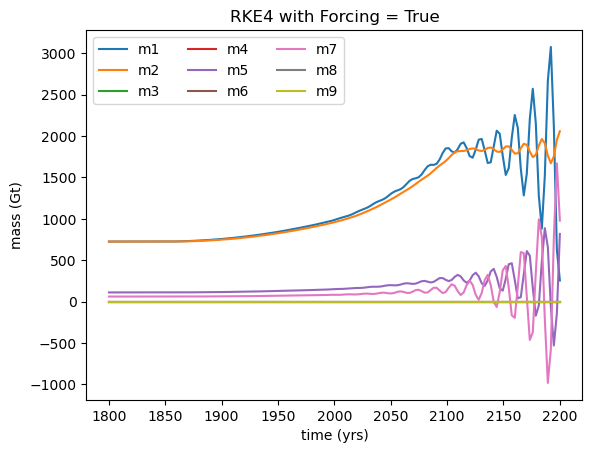

In [12]:
plt.plot(rungekutta[0],rungekutta[1])
plt.title(f'RKE4 with Forcing = {FORCING}'), plt.xlabel('time (yrs)'), plt.ylabel('mass (Gt)'), plt.legend(label_arr, ncol=3)

plt.show()

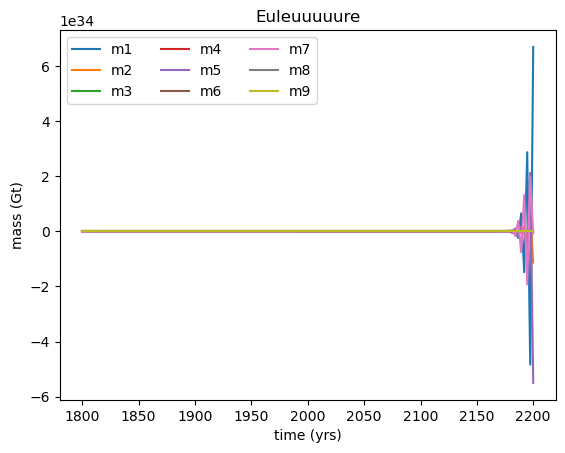

In [13]:
plt.plot(testing_euler[0],testing_euler[1])
plt.title('Euleuuuuure'), plt.xlabel('time (yrs)'), plt.ylabel('mass (Gt)'), plt.legend(label_arr, ncol=3)

plt.show()

In [14]:
def emissions(yr):

    # Function defining A2 emission scenario over the interval 1990-2100
    # extended to pre-industrial (assuming linear increase from 0 in 1850 to 1900) and assuming full cessation of CO_2 input at 2101
    #
    # Example of use:
    #     import numpy as np
    #     import matplotlib.pyplot as plt
    #     yr = np.arange(0,2500, 10)
    #     e = emissions(yr)
    #     plt.plot(yr, e)
    #     plt.show()

    # For additional information see http://www.grida.no/climate/ipcc/emission

    t_yr = np.array([0, 1850, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110, 2120, 10000])

    # CO2 forcing stops at 2100: note that need some zeros close in time to approximate stepwise shutoff with linear interp

    e_GtC_yr = np.array([0, 0,  6.875, 8.125, 9.375, 12.5, 14.375, 16.25, 17.5, 19.75, 21.25, 23.125, 26.25, 28.75, 0, 0, 0])

    e = np.interp(yr, t_yr, e_GtC_yr)

    return e

In [15]:
def plotEmissions(t_0, t_f):
    n = 1000
    t = np.linspace(start=t_0,stop=t_f,num=n)
    y = np.zeros(n)
    
    for i in range(len(t)):
        y[i] = emissions(t[i])
    
    plt.plot(t,y)

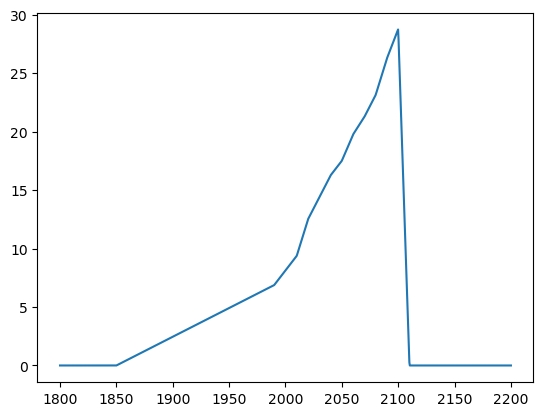

In [16]:
plotEmissions(xinitial,xfinal)